## **1. Install the prereqs**

In [1]:
!pip install pyxdf
!pip install mne

  Using cached pyxdf-1.16.3-py2.py3-none-any.whl (15 kB)


In [2]:
import numpy as np
import os
from yaml import load, Loader
from pyxdf import load_xdf
from mne import create_info, channels
from mne.io import RawArray, Raw
import matplotlib.pyplot as plt

## **2. Read EEG File**

In [3]:
xdf_file = "sub-P001_ses-S001_task-T1_run-001_eeg.xdf"

In [4]:
print('Parsing streams')
eeg_stream, marker_stream = [], []
eeg_stream_type = "EXG"
markers_stream_type = "Markers"
streams, header = load_xdf(xdf_file)
for i in range(len(streams)):
    if streams[i]['info']['type'][0] in [eeg_stream_type, 'EEG']:
        print("Found %s stream in %s" % (eeg_stream_type, os.path.basename(xdf_file)))
        eeg_stream.append(streams[i])
    elif streams[i]['info']['type'][0] == markers_stream_type:
        print("Found %s stream in %s" % (markers_stream_type, os.path.basename(xdf_file)))
        marker_stream.append(streams[i])

Parsing streams
Found Markers stream in sub-P001_ses-S001_task-T1_run-001_eeg.xdf
Found EXG stream in sub-P001_ses-S001_task-T1_run-001_eeg.xdf


In [5]:
eeg_stream[0]

{'info': defaultdict(list,
             {'name': ['EmotivDataStream-EEG'],
              'type': ['EEG'],
              'channel_count': ['19'],
              'channel_format': ['double64'],
              'source_id': ['EPOCX-E20201C9'],
              'nominal_srate': ['128.0000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['3733004.859920900'],
              'uid': ['bc10f248-0cf6-42ce-a35b-5e1f217d5a65'],
              'session_id': ['default'],
              'hostname': ['Autism-M800-1'],
              'v4address': [None],
              'v4data_port': ['16573'],
              'v4service_port': ['16573'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [defaultdict(list,
                           {'manufacturer': ['Emotiv'],
                            'channels': [defaultdict(list,
                                         {'channel': [defaultdict(li

In [6]:
print("Extracting EEG info...")
# get channel names
ch_names = []
if eeg_stream[0]['info']['desc'][0]:
    print("EEG channel names found")
    for i in range(len(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'])):
        ch_names.append(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0])
print('Channels: ', ch_names)

# get sampling frequency
sfreq = float(eeg_stream[0]['info']['nominal_srate'][0])
print('Sampling Frequency: ', sfreq)

# Create MNE info object
eeg_info = create_info(ch_names, sfreq, ch_types='eeg')

Extracting EEG info...
EEG channel names found
Channels:  ['Timestamp', 'Counter', 'Interpolate', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'HardwareMarker', 'Markers']
Sampling Frequency:  128.0


In [7]:
print(eeg_info)

<Info | 7 non-empty values
 bads: []
 ch_names: Timestamp, Counter, Interpolate, AF3, F7, F3, FC5, T7, P7, O1, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 128.0 Hz
>


In [8]:
for n in range(len(eeg_stream)):
    # Create MNE Raw object
    eeg_data = np.transpose(eeg_stream[n]['time_series'])
    eeg_data = eeg_data / 1e6
    print(eeg_data.shape)
    eeg_raw = RawArray(eeg_data, eeg_info)
    
    eeg_raw.set_channel_types({'Timestamp':'misc', 'Counter':'misc', 'Interpolate':'misc', 'HardwareMarker':'misc', 'Markers':'misc'})
    
    # Set montage

    standard_1020_montage = channels.make_standard_montage('standard_1020')
    eeg_raw = eeg_raw.set_montage(standard_1020_montage)

print(eeg_raw)

(19, 10752)
Creating RawArray with float64 data, n_channels=19, n_times=10752
    Range : 0 ... 10751 =      0.000 ...    83.992 secs
Ready.
<RawArray | 19 x 10752 (84.0 s), ~1.6 MB, data loaded>


In [9]:
eeg_df = eeg_raw.to_data_frame()
eeg_df

,time,Timestamp,Counter,Interpolate,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,HardwareMarker,Markers
0,0,1655.233756,0.000093,0.0,4138.077,4104.744,4195.897,4189.615,4148.205,4099.744,4127.564,4144.103,4258.590,4005.897,4368.077,4310.769,4208.205,4409.231,0.0,0.0
1,8,1655.233795,0.000029,0.0,4147.564,4138.077,4191.795,4201.667,4199.231,4135.641,4146.923,4120.128,4268.333,4133.718,4444.231,4289.231,4280.769,4365.769,0.0,0.0
2,16,1655.233795,0.000030,0.0,4158.333,4150.385,4205.000,4215.128,4205.385,4139.487,4154.487,4126.667,4264.103,4122.179,4457.436,4304.231,4288.333,4379.744,0.0,0.0
3,23,1655.233795,0.000031,0.0,4130.513,4126.667,4180.641,4187.564,4131.795,4118.718,4132.564,4100.128,4221.795,4071.282,4431.923,4274.231,4265.256,4352.436,0.0,0.0
4,31,1655.233795,0.000032,0.0,4115.769,4116.154,4166.923,4173.974,4122.179,4106.923,4120.897,4091.538,4205.641,4069.744,4417.308,4251.667,4251.410,4331.795,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,83961,1655.233879,0.000023,0.0,4123.333,4111.667,4172.436,4130.256,4075.897,4134.359,4056.795,4071.026,4151.923,4039.872,4432.692,4258.590,4233.846,4323.974,0.0,0.0
10748,83969,1655.233879,0.000024,0.0,4121.795,4110.128,4177.692,4127.949,4083.974,4133.333,4063.846,4073.077,4153.462,4063.590,4435.769,4260.897,4244.359,4337.179,0.0,0.0
10749,83977,1655.233879,0.000025,0.0,4136.538,4119.487,4180.641,4135.897,4100.256,4147.949,4074.487,4077.821,4159.359,4078.718,4441.410,4265.641,4248.718,4335.385,0.0,0.0
10750,83984,1655.233879,0.000026,0.0,4138.077,4119.359,4170.385,4140.128,4102.308,4144.231,4060.897,4066.026,4144.231,4054.103,4431.795,4252.692,4236.410,4311.923,0.0,0.0


## **3. Plot the EEG data**

Using matplotlib as 2D backend.


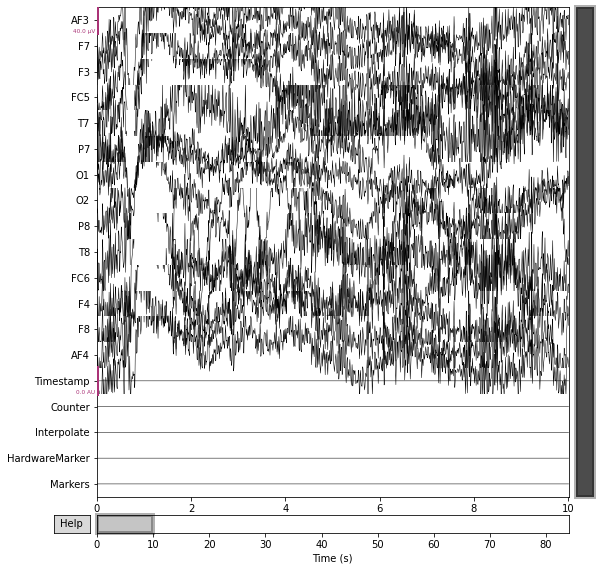

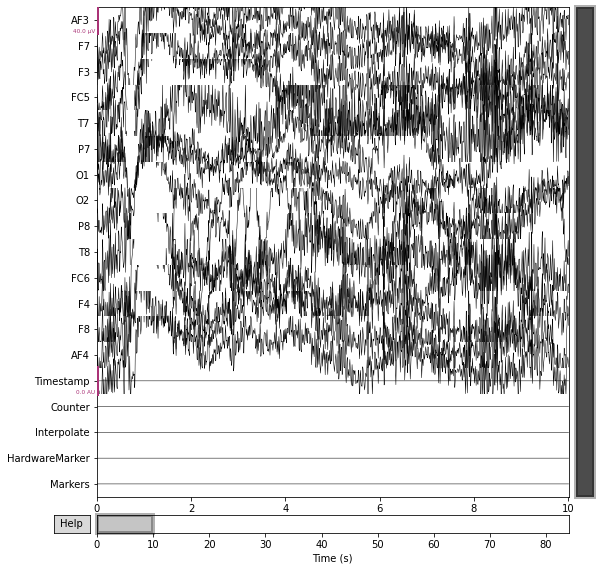

In [10]:
eeg_raw.plot()

## **4. Filter EEG data and plot again**

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 1.00 Hz
- Upper transition bandwidth: 6.25 Hz
- Filter length: 423 samples (3.305 sec)



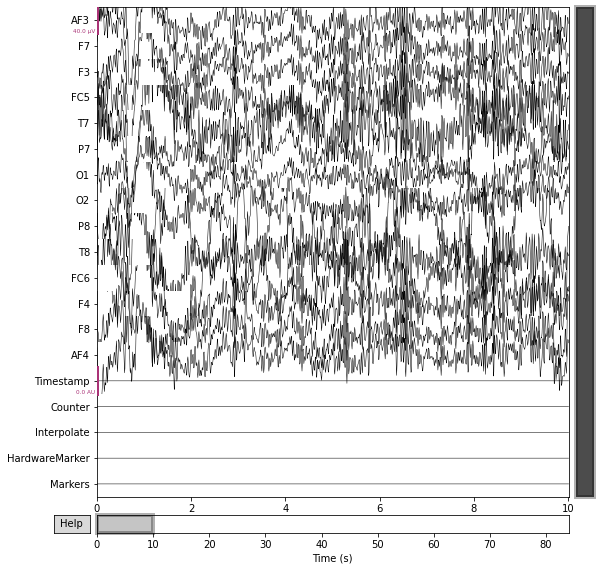

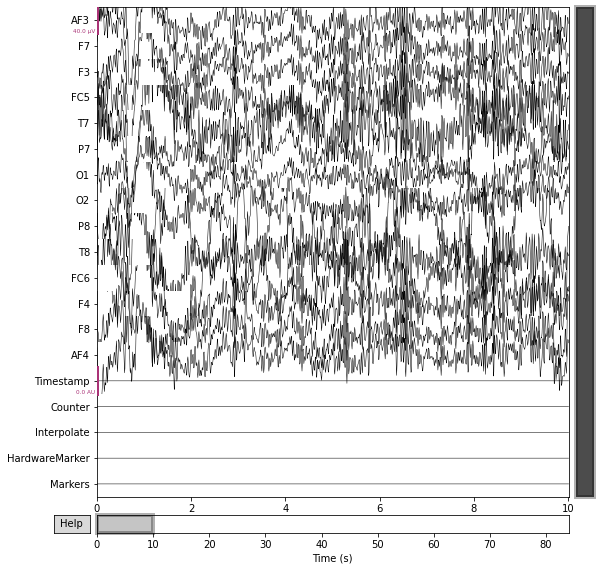

In [17]:
eeg_raw_filt = eeg_raw.copy().filter(l_freq=1., h_freq=25., method='fir', fir_design='firwin', phase='minimum')
eeg_raw_filt.plot()

## **5. Spectrum**

Effective window size : 16.000 (s)


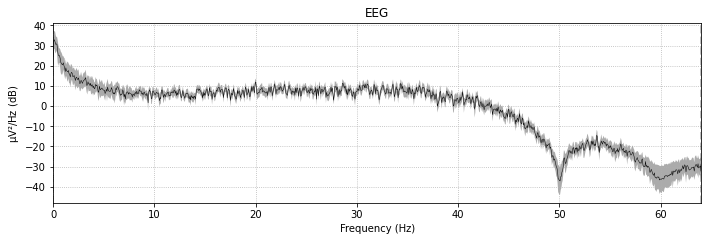

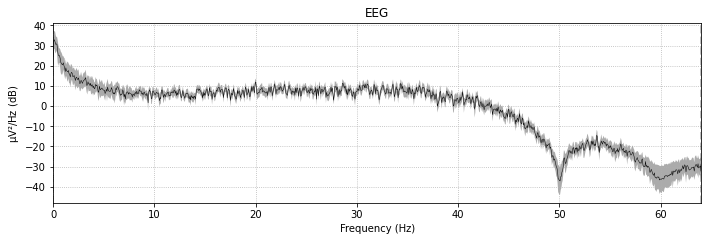

In [18]:
eeg_raw.plot_psd(average=True)

Effective window size : 16.000 (s)


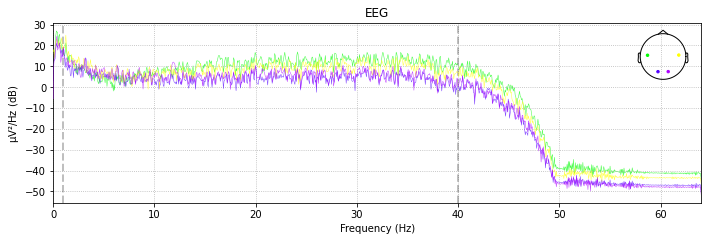

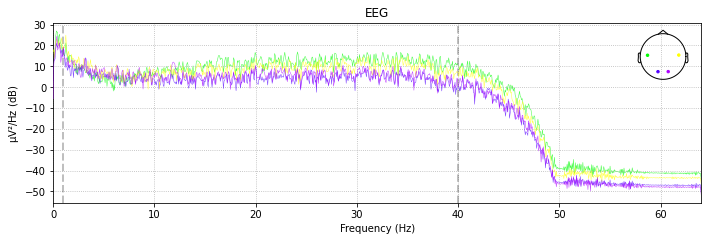

In [16]:
eeg_raw_filt.plot_psd(picks=['O1','O2','T7','T8'])